# Исследование по сведению к оптимизационной задаче

Отклонение через период связано с отклонением в начальный момент времени через матрицу монодромии:
$$
\Delta x(T)=M\Delta x(0).
$$
В нашей работе для нахождения максимального отклонения мы проводили испытания Монте-Карло для
$$
\Delta x(0) \in \mathcal{N}(0, \Sigma),
$$
где $\Sigma$ есть диагональная матрица стандартных отклонений (навигационных неопредеденностей):
$$
\Sigma=
\begin{bmatrix}
\sigma_r & 0   & 0   & 0   & 0   & 0 \\
0   & \sigma_r & 0   & 0   & 0   & 0 \\
0   & 0   & \sigma_r & 0   & 0   & 0 \\
0   & 0   & 0   & \sigma_v & 0   & 0 \\
0   & 0   & 0   & 0   & \sigma_v & 0 \\
0   & 0   & 0   & 0   & 0   & \sigma_v \\
\end{bmatrix}.
$$
Генерируя множество точек согласно правилу выше, можно быстро получать $x(T)$ с помощью полученной автоматичеким дифференцированием формулы Тейлора произвольного порядка.

## 1. Применимость линейной теории к задаче трех тел

In [18]:
from utils.libration_sense import *

In [19]:
orbit_type = 'L1'
orbit_num = 192

# матрица монодромии
M = get_monodromy_matrix(orbit_type, orbit_num)
print(np.linalg.eigvals(M))

# начальная точка для интегратора
x0, z0, vy0, T, _, __ = initial_state_parser(orbit_type, orbit_num)
initial_state_da = array.identity(6)
initial_state_da[0] += x0  # x
initial_state_da[2] += z0  # z
initial_state_da[4] += vy0  # v_y
initial_state_cons = initial_state_da.cons()  # положения и скорости центральной точки

# генерируем положения вокруг initial_state из нормального распределения с клиппингом
std_pos = km2du(8)  # 8 км
std_vel = kmS2vu(0.05e-3)  # 0.05 м/c
std_devs = np.array([std_pos] * 3 + [std_vel] * 3)
initial_deviations = np.random.normal(0, std_devs, (10000, 6))
limits = np.array([3 * std_pos] * 3 + [3 * std_vel] * 3)
initial_deviations = np.clip(initial_deviations, -limits, limits) 

new_initial_states = initial_state_cons + initial_deviations  # отклонения от начального положения
print(type(new_initial_states))
print(initial_deviations.shape)

[-0.46347836+0.88610824j -0.46347836-0.88610824j  0.80067349+0.59910096j
  0.80067349-0.59910096j  1.00645583+0.j          0.99358558+0.j        ]
<class 'numpy.ndarray'>
(10000, 6)


In [7]:
i = 0
residuals = []
for (new_initial_state, initial_deviation) in zip(new_initial_states, initial_deviations):
    new_initial_state_da = array.identity(6)
    new_initial_state_da[0] += new_initial_state[0]  # x
    new_initial_state_da[2] += new_initial_state[2]  # z
    new_initial_state_da[4] += new_initial_state[4]  # v_y

    xf = RK78(new_initial_state_da, 0.0, T, CR3BP)
    delta_x_T_integrate = xf.cons() - initial_state_cons
    delta_x_T_monodromy = M @ initial_deviation

    residuals.append(np.linalg.norm(delta_x_T_integrate - delta_x_T_monodromy))
    i += 1
    print(i)
    if i == 10:
        break 

1
2
3
4
5
6
7
8
9
10


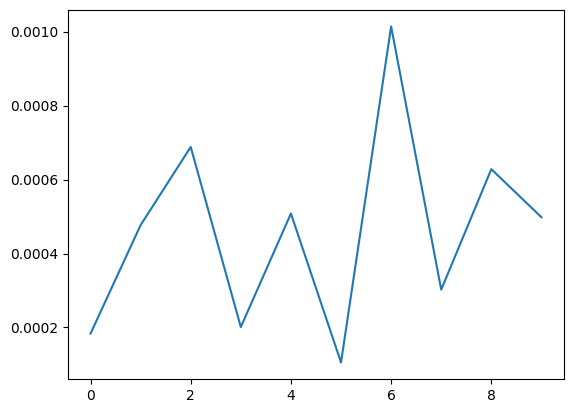

In [8]:
import matplotlib.pyplot as plt

plt.plot(range(len(residuals)), residuals)

## 2. Максимальное отклонение как решение оптимизационной задачи

Если за $x$ обозначить отклонение в начальный момент времени (в фазовом пространстве), то
$$
 x^TA^TA x \longrightarrow \max_{x\in E}.
$$

In [29]:
Mrr = M[:3, :3]
Mrv = M[:3, 3:]
A = np.hstack([Mrr, Mrv])
alpha = 1e-8
n = A.shape[1]
ATA = A.T @ A
print(n)
print(np.linalg.cond(ATA))
print(np.linalg.eigvals(ATA))

def f(x, Q):
    res = -np.dot(x, Q @ x)
    # print(f'func = {res}')
    return res

def nabla_f(x, Q):
    res = -2 * Q @ x
    return res

bounds = [(-3*std_pos, 3*std_pos)] * 3 + [(-3*std_vel, 3*std_vel)] * 3

6
1.964575207762393e+18
[ 6.88947243e+01  3.84429997e+01  2.54343613e-01  7.35242368e-16
  1.58725745e-15 -9.90725687e-16]


In [31]:
from scipy.optimize import minimize

np.random.seed(42)
ig = np.random.normal(0, std_devs)
res = minimize(f, ig, args=(ATA,), jac=nabla_f, bounds=bounds, method='L-BFGS-B', options={'disp': True})

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.96537D-08    |proj g|=  1.57834D-04

At iterate    1    f= -1.97552D-06    |proj g|=  3.75053D-05
  ys=-2.619E-06  -gs= 5.962E-07 BFGS update SKIPPED

At iterate    2    f= -1.99103D-06    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      2      3      8     1     6   0.000D+00  -1.991D-06
  F =  -1.9910265390951115E-006

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


In [32]:
opt_initial_state_da = array.identity(6)
opt_initial_state_da[0] += res.x[0] + x0  # x
opt_initial_state_da[1] += res.x[1]  # y
opt_initial_state_da[2] += res.x[2] + z0  # z
opt_initial_state_da[3] += res.x[3]  # vx
opt_initial_state_da[4] += res.x[4] + vy0  # vy
opt_initial_state_da[5] += res.x[5]  # vz

with DA.cache_manager():
    r_f =  RK78(opt_initial_state_da, 0.0, T, CR3BP).cons()[:3]

r_0 = initial_state_cons[:3]

print(du2km(np.linalg.norm(r_f - r_0)))

541.8455069934131


In [33]:
maxdev_montekarlo_du = get_maxdeviation(orbit_type, orbit_num, std_pos, std_vel, derorder=2, number_of_points=1_000_000)
maxdev_montekarlo_km = du2km(maxdev_montekarlo_du)
print(maxdev_montekarlo_km)

464.0807837089994


In [30]:
maxdev_montekarlo_du = get_maxdeviation(orbit_type, orbit_num, std_pos, std_vel, number_of_points=4_000_000)
maxdev_montekarlo_km = du2km(maxdev_montekarlo_du)
print(maxdev_montekarlo_km)

447.06726723830866


In [111]:
maxdev_montekarlo_du = get_maxdeviation(orbit_type, orbit_num, std_pos, std_vel, number_of_points=8_000_000)
maxdev_montekarlo_km = du2km(maxdev_montekarlo_du)
print(maxdev_montekarlo_km)

453.2433354676557
